In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []

In [2]:
import pandas as pd

# Hierarchical Forecasting with PyAF

In this document , we give a use case of hierarchcial forecasting wioth PyAF. 

We study the problem of forecasting France wine exportation by wine type (Champagne , Bordeaux, etc), variant (red , white, sparkling etc) and destination country.

A dataset has been built based on French government opendata gratefully provided by the foreign trade ministry. This dataset is available here : https://github.com/antoinecarme/TimeSeriesData/tree/master/Stat_FR_CommExt. 

Please note that the original dataset is generic and contains export data for all foreign trade products to all possible countries with a significant level of detail (cars, crops, living animals , legal weapons , ...).



## Data Overview

The dataset is a collection of 2872 monthly time series overserved on a period ranging from 2012-01-01 to 2016-09-01.

Each time series has 50 rows (some data are missing in 2015 , under investigation) and represents the export of a given type of wine, a given variant to a unique contry.

The time series column name is built by concatenating the three above informations.

To simplify, we will reduce the number of countries to the 10 most signficant (`wine-friendly`) ones. This reduces the number of columns to 176 ;)

In [3]:
import datetime

filename = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/Stat_FR_CommExt/merged/French_Wine_Export_in_Euros_Some_Countries.csv"

French_Wine_Export_in_Euros_DF = pd.read_csv(filename);

lDateColumn = 'Month';
French_Wine_Export_in_Euros_DF[lDateColumn] = French_Wine_Export_in_Euros_DF[lDateColumn].apply(lambda x : datetime.datetime.strptime(str(x), "%Y-%m-%d"))

French_Wine_Export_in_Euros_DF.head(5)


,Month,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
0,2012-01-01,1131852,571940,257116,140013,357516,344274,51043,329883,624695,...,800628,650236,1127393,783952,1513332,335710,916965,314654,35418,1260510
1,2012-02-01,857289,585556,187917,89805,505896,424953,80220,239242,899144,...,795356,680567,188827,868576,1277664,197072,318522,516140,36604,2136484
2,2012-03-01,1438501,834142,679281,103577,583887,352675,102980,394945,1093638,...,873858,1318538,856382,627236,2343448,132200,605914,410308,43197,3264810
3,2012-04-01,986602,866221,523202,203456,515903,403517,52773,260953,874217,...,1004028,919493,460815,829432,1861188,128164,472522,290407,45396,2631466
4,2012-05-01,991668,1061702,611369,80327,767522,627232,78115,680323,994697,...,2098300,632778,239200,934532,2215922,202210,337894,284868,41469,2945175


In [4]:
French_Wine_Export_in_Euros_DF.describe()

,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,ALSACE_BLANC_OTHER,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
count,5.000000e+01,5.000000e+01,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,...,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01
mean,1.189956e+06,8.037735e+05,428923.380000,119348.360000,6.173951e+05,414037.100000,88636.820000,361437.900000,8.035454e+05,38337.801569,...,1.607702e+06,8.523710e+05,7.498312e+05,1.072562e+06,2.876061e+06,235678.640000,5.760031e+05,4.986103e+05,52907.080000,2.912355e+06
std,2.780384e+05,1.691507e+05,158179.648178,65116.609016,2.765474e+05,116398.158498,68347.582681,110140.042643,2.732401e+05,6088.988573,...,7.064099e+05,2.458533e+05,3.592653e+05,4.307817e+05,1.366642e+06,140071.773582,2.398091e+05,1.720202e+05,9667.885799,6.675896e+05
min,5.477480e+05,3.514620e+05,88329.000000,19546.000000,3.131500e+05,168388.000000,31864.000000,192553.000000,3.085880e+05,18550.156250,...,7.935600e+05,3.992940e+05,1.888270e+05,5.558550e+05,1.277664e+06,77550.000000,2.053840e+05,2.311020e+05,35238.000000,1.260510e+06
25%,1.004816e+06,6.791068e+05,316753.500000,82278.500000,4.801042e+05,333264.500000,52845.750000,293690.250000,6.061862e+05,35457.417067,...,1.047350e+06,6.819278e+05,5.089532e+05,7.219495e+05,2.025437e+06,152307.750000,3.751060e+05,3.725818e+05,46721.000000,2.500847e+06
50%,1.161726e+06,8.070940e+05,445554.500000,98656.000000,5.449660e+05,401774.500000,76561.500000,335180.000000,7.884350e+05,38715.394123,...,1.506712e+06,8.120535e+05,7.065070e+05,9.246160e+05,2.519672e+06,203395.000000,5.414685e+05,4.674045e+05,52305.000000,2.896628e+06
75%,1.323582e+06,8.880218e+05,542924.000000,161694.000000,6.549058e+05,515408.000000,102011.750000,417475.000000,8.980862e+05,41900.001008,...,1.936743e+06,1.023269e+06,9.285735e+05,1.207832e+06,3.018630e+06,257873.500000,7.998980e+05,6.143272e+05,59756.250000,3.380802e+06
max,2.166585e+06,1.216720e+06,857207.000000,317661.000000,1.871515e+06,635447.000000,510151.000000,680323.000000,1.458234e+06,52823.280702,...,3.946934e+06,1.334550e+06,1.755449e+06,2.312776e+06,8.652432e+06,879037.000000,1.076535e+06,1.063568e+06,71487.000000,4.664273e+06


To give an example, the following plot compares the export of Champagne to Germany, Japan and UK:  

In [5]:
%matplotlib inline

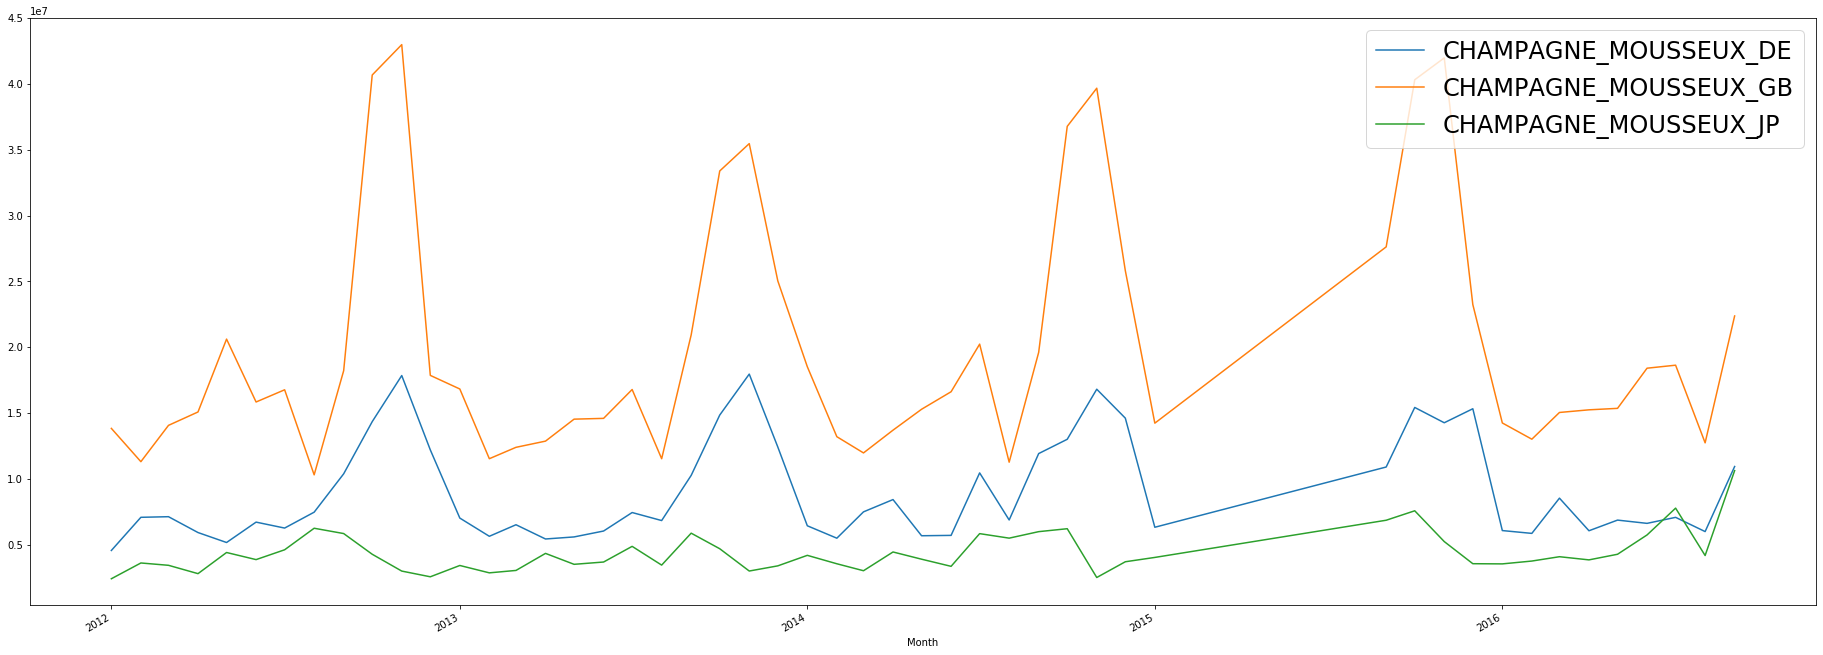

In [6]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['CHAMPAGNE_MOUSSEUX_DE', 'CHAMPAGNE_MOUSSEUX_GB' , 'CHAMPAGNE_MOUSSEUX_JP'],
                                   figsize=(32 , 12)).legend(loc='best', fontsize=24)

While the next one compares US consumption (in Euros) of red and white Bordeaux ;)

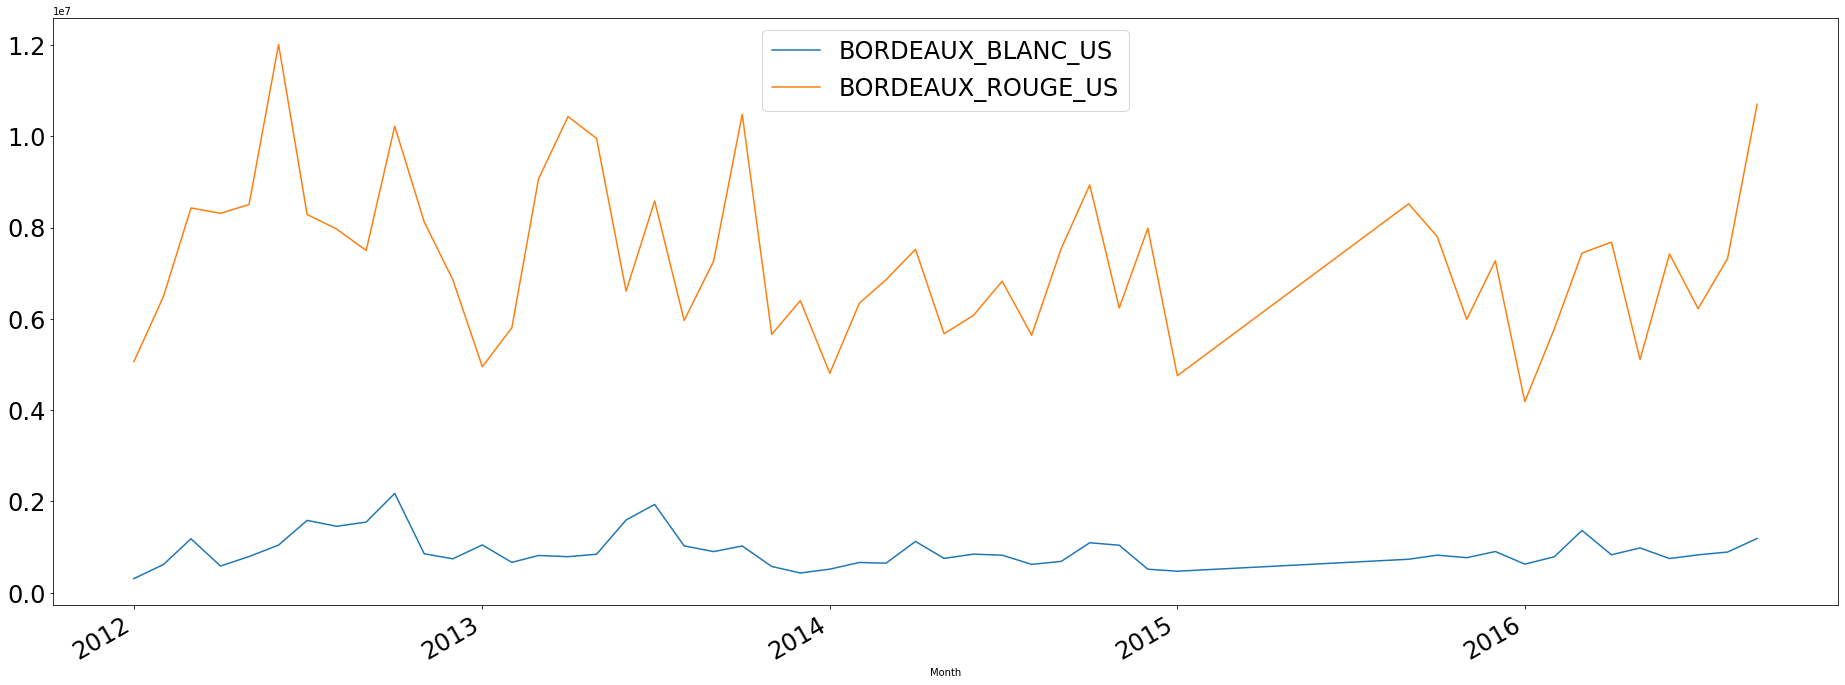

In [7]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_US'],
                                    fontsize = 24,
                                    figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [8]:
CN_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_CN') ]
French_Wine_Export_in_Euros_DF[CN_columns].describe()


,ALSACE_BLANC_CN,BEAUJOLAIS_ROUGE_CN,BORDEAUX_BLANC_CN,BORDEAUX_ROUGE_CN,BOURGOGNE_BLANC_CN,BOURGOGNE_ROUGE_CN,CHAMPAGNE_MOUSSEUX_CN,EUROPE_ROUGE_CN,FRANCE_BLANC_CN,FRANCE_MOUSSEUX_CN,FRANCE_ROUGE_CN,LANGUEDOC_ROUGE_CN,LOIRE_BLANC_CN,LOIRE_ROUGE_CN,OTHER_ROUGE_CN,RHÔNE_ROUGE_CN
count,50.000000,50.00000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01
mean,119348.360000,130292.47000,4.993186e+05,1.138432e+07,242575.340000,7.436432e+05,6.225160e+05,8.313372e+05,12978.062000,93298.256667,11185.281403,1.304245e+06,48771.330000,92016.740000,52969.948000,7.498312e+05
std,65116.609016,102214.45714,2.936971e+05,3.081051e+06,99492.736867,4.176045e+05,3.812781e+05,2.337996e+05,24705.479992,63521.773261,13888.069451,6.352887e+05,27922.200988,54704.609614,36129.014739,3.592653e+05
min,19546.000000,5833.00000,1.678740e+05,5.377235e+06,75396.000000,2.725460e+05,1.976760e+05,3.270090e+05,0.000000,20488.500000,260.500000,4.916860e+05,16643.500000,15325.000000,6337.750000,1.888270e+05
25%,82278.500000,66206.50000,3.117738e+05,9.737536e+06,171633.250000,4.214805e+05,3.897600e+05,6.529608e+05,1607.250000,46355.750000,4759.017857,9.207640e+05,31191.250000,54588.250000,28779.650000,5.089532e+05
50%,98656.000000,98427.50000,4.148980e+05,1.039686e+07,237099.500000,6.060540e+05,5.299100e+05,8.078685e+05,6237.750000,82644.583333,8837.333333,1.211934e+06,37845.750000,77491.500000,44118.875000,7.065070e+05
75%,161694.000000,158673.75000,5.623658e+05,1.316721e+07,308119.750000,9.648268e+05,7.029695e+05,9.859902e+05,14842.000000,118693.250000,12869.584821,1.416010e+06,62140.375000,119915.500000,62176.000000,9.285735e+05
max,317661.000000,453985.00000,1.890312e+06,1.905088e+07,535157.000000,2.021852e+06,2.103130e+06,1.367882e+06,163701.000000,366064.500000,96564.222222,3.607517e+06,151128.000000,272948.000000,179114.750000,1.755449e+06


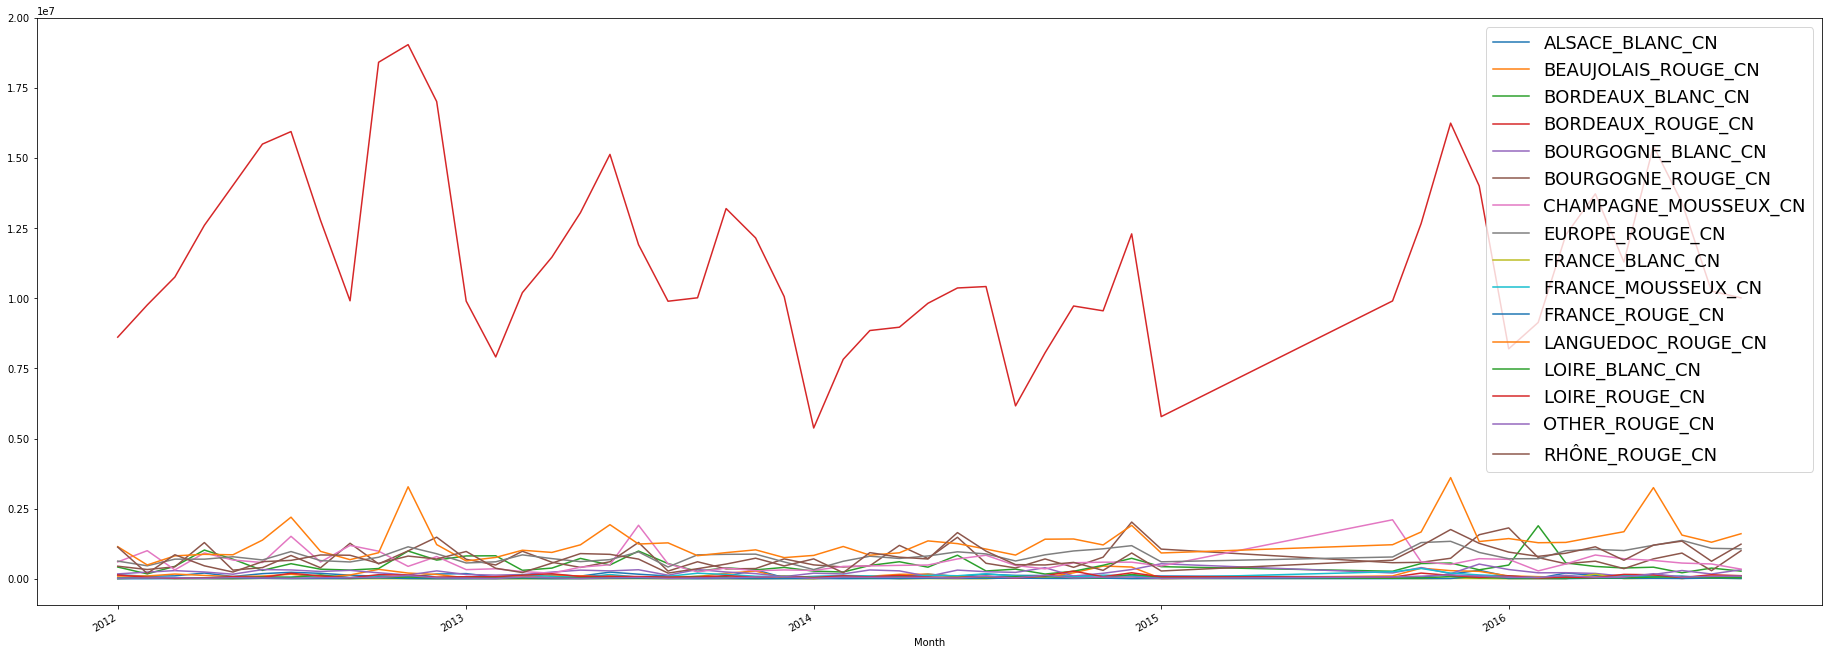

In [9]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    CN_columns,
                                   figsize=(32 , 12)).legend(fontsize=18)

In [10]:
Wines = "ALSACE BEAUJOLAIS BORDEAUX BOURGOGNE CHAMPAGNE EUROPE FRANCE LANGUEDOC LOIRE OTHER RHÔNE".split();
Variants = ['BLANC' , 'MOUSSEUX' , 'ROUGE'];
Countries = ['GB', 'US', 'DE', 'BE', 'CN', 'JP', 'CH', 'HK', 'NL', 'CA' , 'OTHER']



In [11]:
# A lot of possibilities , but only 176 are available ;)
len(Wines) * len(Variants) * len(Countries) 

363

In [12]:
from IPython.display import display


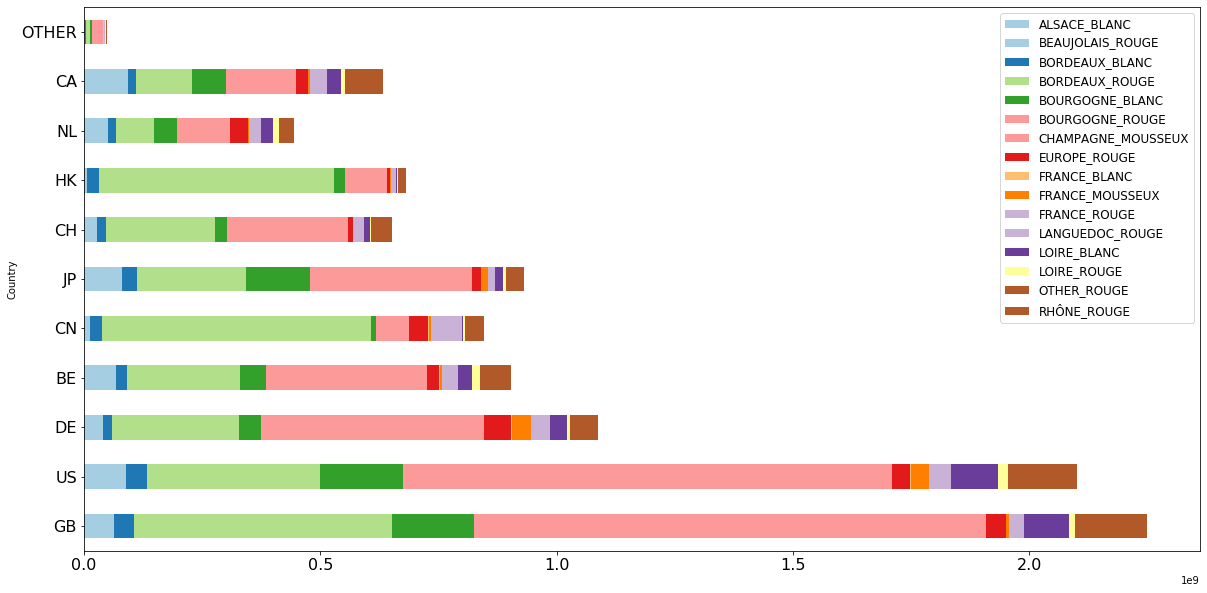

In [13]:
rows = [];
cols = []
for cntry in Countries:
    cntry_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_' + cntry) ]
    cols = []
    row = [cntry];
    for col in cntry_columns:
        col1 = col.replace('_' + cntry , "")
        sum1 = French_Wine_Export_in_Euros_DF[col].sum()
        row.append(sum1);
        cols.append(col1);
    rows.append(row);

plot_df = pd.DataFrame(rows , columns=['Country'] + cols);

    
plot_df.set_index('Country').plot.barh(stacked=True, figsize=(20,10), fontsize = 16, colormap='Paired').legend(loc='best', fontsize=12)

## Grouping Definition


Here, we start by defining as hierarchical model to forecast wine export by forecasting country and wine type and variant exports.

A wine type export is computed by aggregating (grouping) all variants exported to all countries.

In this section, we describe the definition of the grouping.
Again, for clarity, we restrict our work to some countries and some wine types and variants.


In [14]:

Regions = ['EUROPE', 'AMERICA', 'EUROPE' , 'EUROPE' , 'ASIA' , 'ASIA' , 'EUROPE',  'ASIA', 'EUROPE' , 'AMERICA' , 'OTHER_REGION']
lDict = dict(zip(Countries , Regions));

# simplify !!!!
Variants = ['BLANC' , 'ROUGE'];
Wines = Wines[0:3];
Countries = Countries[0:5]

In [15]:
# Grouping definition
lGroups = {}
lGroups["Country"] = Countries
lGroups["Variant"] = Variants
lGroups["Wine"] = Wines

lHierarchy = {};
lHierarchy['Levels'] = None;
lHierarchy['Data'] = None;
lHierarchy['Groups']= lGroups;
# the most important !!!!
lHierarchy['GroupOrder']= ["Wine", "Variant", "Country"]; # group by Wine first, then by variant, etc
lHierarchy['Type'] = "Grouped";
    


We want here to group first by Wine, then by variant and by country. The hierarchy is automatically created based on available columns. 

The hierarchy has been specified this way :

In [16]:
lHierarchy

{'Levels': None,
 'Data': None,
 'Groups': {'Country': ['GB', 'US', 'DE', 'BE', 'CN'],
  'Variant': ['BLANC', 'ROUGE'],
  'Wine': ['ALSACE', 'BEAUJOLAIS', 'BORDEAUX']},
 'GroupOrder': ['Wine', 'Variant', 'Country'],
 'Type': 'Grouped'}


Column names are of the type "w_v_c" where w is the wine type, v is the variant and c is the country (in the group order). A different group order leads to a differnet hierarchy and differnet models. The group order has a significant business semantics. 

When aggregated , a group name is emptied :
   * **"_BLANC_BE"** is the aggreagtion of all wine types of variant 'BLANC' that are exported to the country 'BE' and
   * **"__CN"** is the aggreagtion of all wine types of all variants that are exported to the country 'CN' (all what China can drink !!!)
   
All these generated names are not always available in our original training dataset (or even in nature, some wine types and variants are not compatible ;). 

The user may also need to adapt the training dataset column names to match the names defined by the automatic grouping (The name 'BORDEAUX_BLANC_DE' reflects a specific group order).

We plot the hierarchy ...


INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


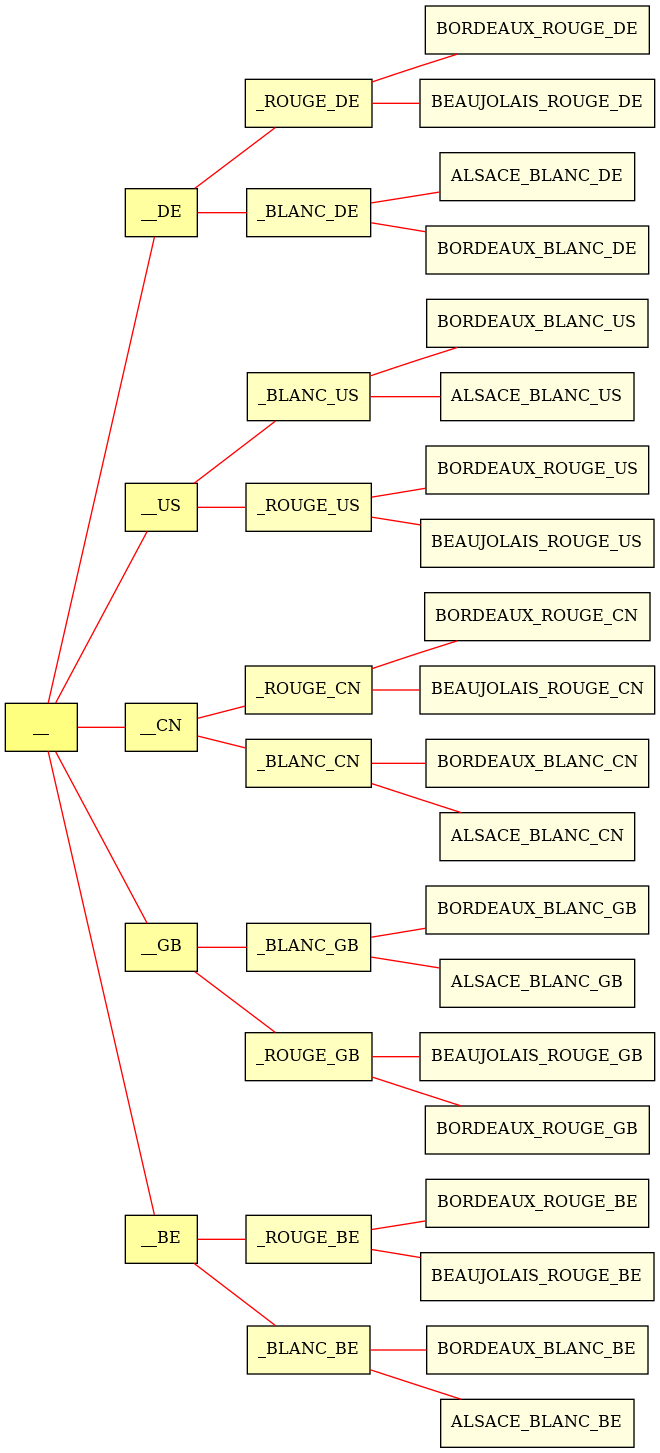

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.2014780044555664


In [17]:
# create a model to plot the hierarchy.
import pyaf.HierarchicalForecastEngine as hautof
lEngine = hautof.cHierarchicalForecastEngine()


lSignalHierarchy = lEngine.plot_Hierarchy(French_Wine_Export_in_Euros_DF , "Month", "Signal", 1, 
                                          lHierarchy, None);

The strcuture levels have been built :

In [18]:
lSignalHierarchy.mStructure

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'_BLANC_BE': {'ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'},
  '_BLANC_CN': {'ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'},
  '_BLANC_DE': {'ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'},
  '_BLANC_GB': {'ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'},
  '_BLANC_US': {'ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'},
  '_ROUGE_BE': {'BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'},
  '_ROUGE_CN': {'BEAUJOLAIS_ROUGE_CN', 'BORDEAU

## Hierarchical Modelling

Here, we build a first model on the previous hierarchy. Thsi will build an internal model for each node of the previous graph.

Note that the lower (most detailed) level data are coming from the datset and higher levels are obtained by aggregating previous levels.  

We discard the last 4 months of the dataset and try to forecast their values. 

In [19]:
# create a hierarchical model and train it
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";

#
N = French_Wine_Export_in_Euros_DF.shape[0];
H = 4;
train_df = French_Wine_Export_in_Euros_DF.head(N-H);


lSignalHierarchy = lEngine.train(train_df , lDateColumn, lSignalVar, 1, lHierarchy, None);

INFO:pyaf.std:START_HIERARCHICAL_TRAINING
INFO:pyaf.hierarchical:TRAINING_HIERARCHICAL_MODELS_LEVEL_SIGNAL [(0, 'ALSACE_BLANC_BE'), (0, 'ALSACE_BLANC_CN'), (0, 'ALSACE_BLANC_DE'), (0, 'ALSACE_BLANC_GB'), (0, 'ALSACE_BLANC_US'), (0, 'BEAUJOLAIS_ROUGE_BE'), (0, 'BEAUJOLAIS_ROUGE_CN'), (0, 'BEAUJOLAIS_ROUGE_DE'), (0, 'BEAUJOLAIS_ROUGE_GB'), (0, 'BEAUJOLAIS_ROUGE_US'), (0, 'BORDEAUX_BLANC_BE'), (0, 'BORDEAUX_BLANC_CN'), (0, 'BORDEAUX_BLANC_DE'), (0, 'BORDEAUX_BLANC_GB'), (0, 'BORDEAUX_BLANC_US'), (0, 'BORDEAUX_ROUGE_BE'), (0, 'BORDEAUX_ROUGE_CN'), (0, 'BORDEAUX_ROUGE_DE'), (0, 'BORDEAUX_ROUGE_GB'), (0, 'BORDEAUX_ROUGE_US'), (1, '_BLANC_BE'), (1, '_BLANC_CN'), (1, '_BLANC_DE'), (1, '_BLANC_GB'), (1, '_BLANC_US'), (1, '_ROUGE_BE'), (1, '_ROUGE_CN'), (1, '_ROUGE_DE'), (1, '_ROUGE_GB'), (1, '_ROUGE_US'), (2, '__BE'), (2, '__CN'), (2, '__DE'), (2, '__GB'), (2, '__US'), (3, '__')]
INFO:pyaf.std:START_TRAINING 'ALSACE_BLANC_BE'
INFO:pyaf.std:START_TRAINING 'BEAUJOLAIS_ROUGE_CN'
INFO:pyaf.std:STAR

INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.027049779891967773
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.029793739318847656
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.02654242515563965
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.0282437801361084
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.036720991134643555
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.030455589294433594
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.029472827911376953
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.03842949867248535
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.03979158401489258
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.03688526153564453
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:

INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('BORDEAUX_ROUGE_US_BU', 3670201.8525633416, 0.3846, 3670201.8525633416, 0.3846)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('BORDEAUX_ROUGE_US_BU', 1279973.4076019498, 0.1988, 1279973.4076019498, 0.1988)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('_BLANC_BE_BU', 195549.86706984605, 0.0927, 225853.5447051733, 0.1098)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('_BLANC_BE_BU', 536239.7343081034, 0.2702, 522244.2641875355, 0.2642)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('_BLANC_CN_BU', 247309.123453371, 0.3872, 237419.5469409291, 0.3689)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('_BLANC_CN_BU', 447221.0158893082, 0.255, 479862.8871668425, 0.2483)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('_BLANC_DE_BU', 473858.77604200575, 0.2715, 516762.08294615545, 0.2515)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('_BLANC_DE_BU', 141608.55178546874, 0.137, 121463.47982179142, 0.1045)
INFO:pyaf.

In [20]:
French_Wine_Export_in_Euros_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 177 entries, Month to RHÔNE_ROUGE_US
dtypes: datetime64[ns](1), float64(56), int64(120)
memory usage: 69.3 KB


In [21]:
lInfo = lEngine.to_json()
lInfo.keys()

dict_keys(['Structure', 'Models'])

In [22]:
lInfo['Structure']

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'_BLANC_BE': {'ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'},
  '_BLANC_CN': {'ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'},
  '_BLANC_DE': {'ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'},
  '_BLANC_GB': {'ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'},
  '_BLANC_US': {'ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'},
  '_ROUGE_BE': {'BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'},
  '_ROUGE_CN': {'BEAUJOLAIS_ROUGE_CN', 'BORDEAU

In [23]:
lInfo['Models'].keys()

dict_keys(['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'])

In [24]:
lInfo['Models']['BORDEAUX_ROUGE_CN']

{'Dataset': {'Time': {'TimeVariable': 'Month',
   'TimeMinMax': ['2012-01-01 00:00:00', '2016-05-01 00:00:00'],
   'Horizon': 1},
  'Signal': 'BORDEAUX_ROUGE_CN',
  'Training_Signal_Length': 46},
 'Model': {'Best_Decomposition': 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle_residue_AR(11)',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend',
  'Cycle': 'NoCycle',
  'AR_Model': 'AR'},
 'Model_Performance': {'MAPE': '0.2216',
  'MASE': '0.7022',
  'MAE': '2110502.468960095',
  'RMSE': '2646130.4232281293',
  'COMPLEXITY': '41'}}

In [25]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance']
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                  Model                RMSE    MAPE
13    BORDEAUX_BLANC_GB   99936.68789248551   0.133
30                   __   6516614.471320466  0.1367
22            _BLANC_DE  141608.55178546874   0.137
3       ALSACE_BLANC_GB   66480.16663925201  0.1402
23            _BLANC_GB   194430.4785616541  0.1475
29            _ROUGE_US  1353323.9885370731  0.1533
34                 __GB  1567222.4394758958  0.1579
18    BORDEAUX_ROUGE_GB  1259434.9100598427  0.1592
28            _ROUGE_GB  1442701.9862164112  0.1611
31                 __BE  1150941.4629769186  0.1693
2       ALSACE_BLANC_DE   144769.4922736975  0.1906
15    BORDEAUX_ROUGE_BE   921082.2727095842  0.1915
24            _BLANC_US   406290.2059059647  0.1927
19    BORDEAUX_ROUGE_US  1279973.4076019498  0.1988
25            _ROUGE_BE   946236.4320116949  0.2045
14    BORDEAUX_BLANC_US  252977.83561553678  0.2096
35                 __US  2096609.4319779796  0.2209
16    BORDEAUX_ROUGE_CN  2646130.4232281293  0.2216
26          

INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


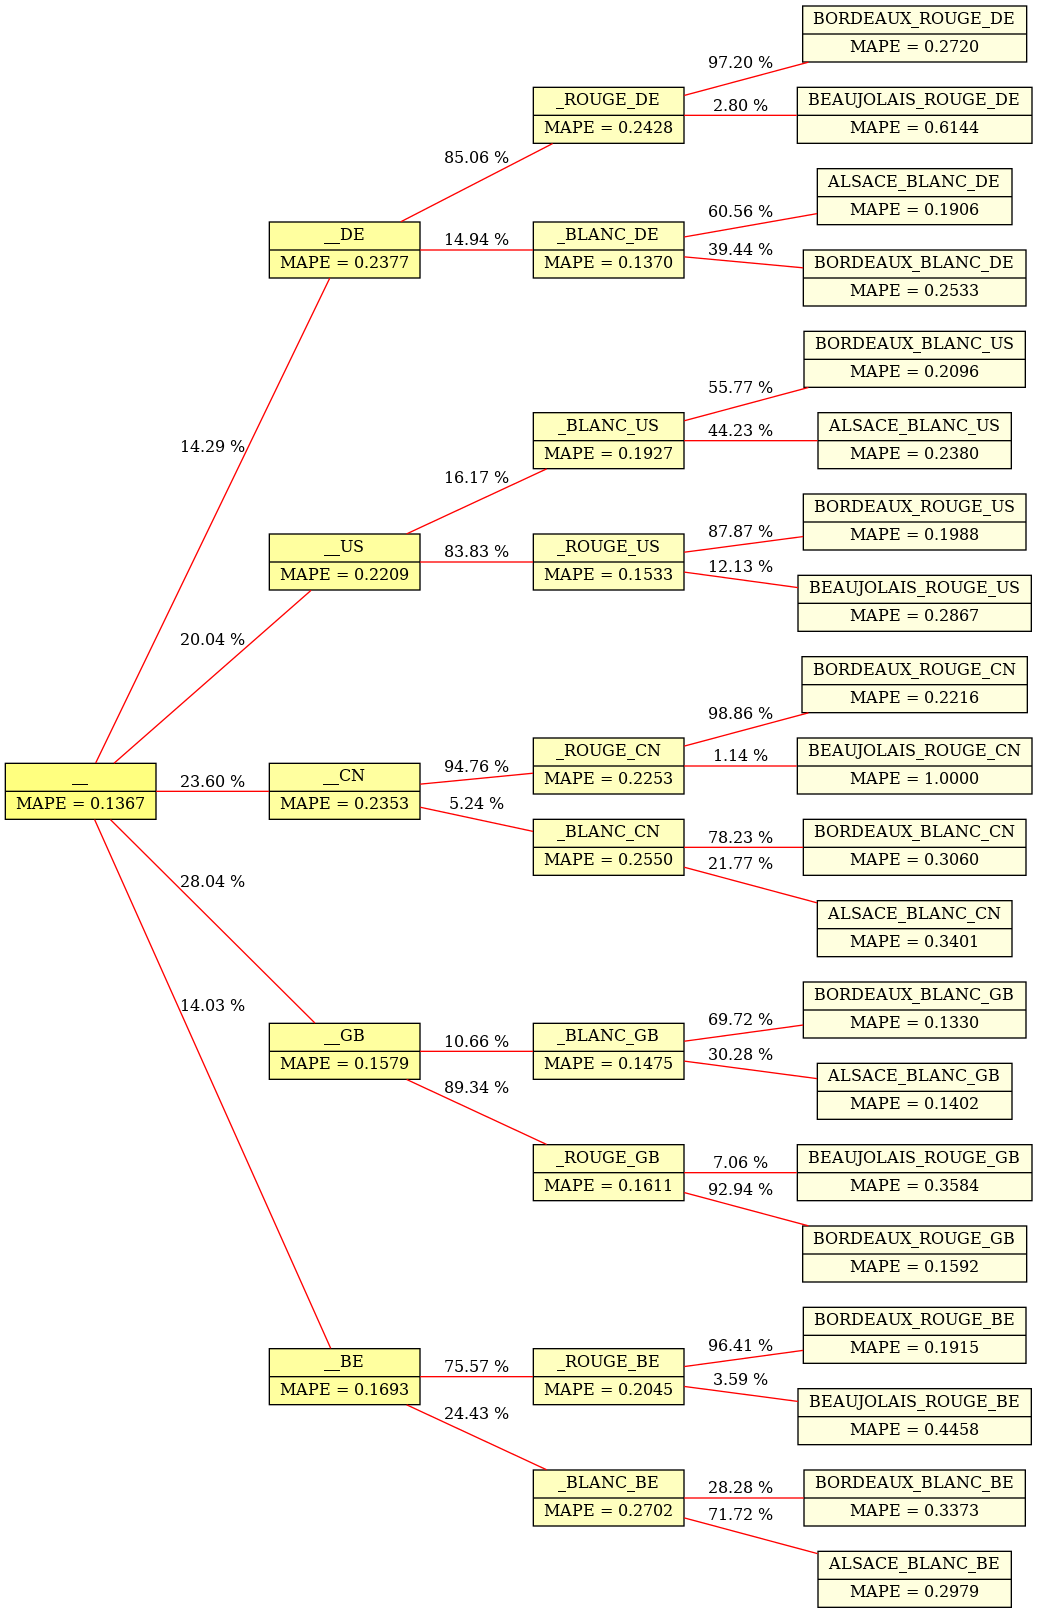

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.2691941261291504


In [26]:
lEngine.mSignalHierarchy.plot()

In [27]:
CN_Engine = lEngine.mSignalHierarchy.mModels[2]['__CN'] # __CN is at hierarchical level 2

In [28]:
CN_Engine.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=<DateOffset: months=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='__CN' Length=46  Min=5739856.0 Max=20299168.0  Mean=12078814.967391305 StdDev=3221460.4046913716
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='Diff___CN' Min=-7241263.5 Max=8724178.0  Mean=57784.19565217391 StdDev=3063515.4226825424
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE 'Diff_'
INFO:pyaf.std:BEST_DECOMPOSITION  'Diff___CN_ConstantTrend_residue_zeroCycle_residue_AR(11)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL 'Diff___CN_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL 'Diff___CN_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL 'Diff___CN_ConstantTrend_residue_zeroCycle_residue_AR(11)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.3787 MAPE_Forecast=0.2353 MAPE_Test=0.0926
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.4745 

INFO:pyaf.std:START_PLOTTING
INFO:pyaf.std:END_PLOTTING_TIME_IN_SECONDS 0.5526976585388184


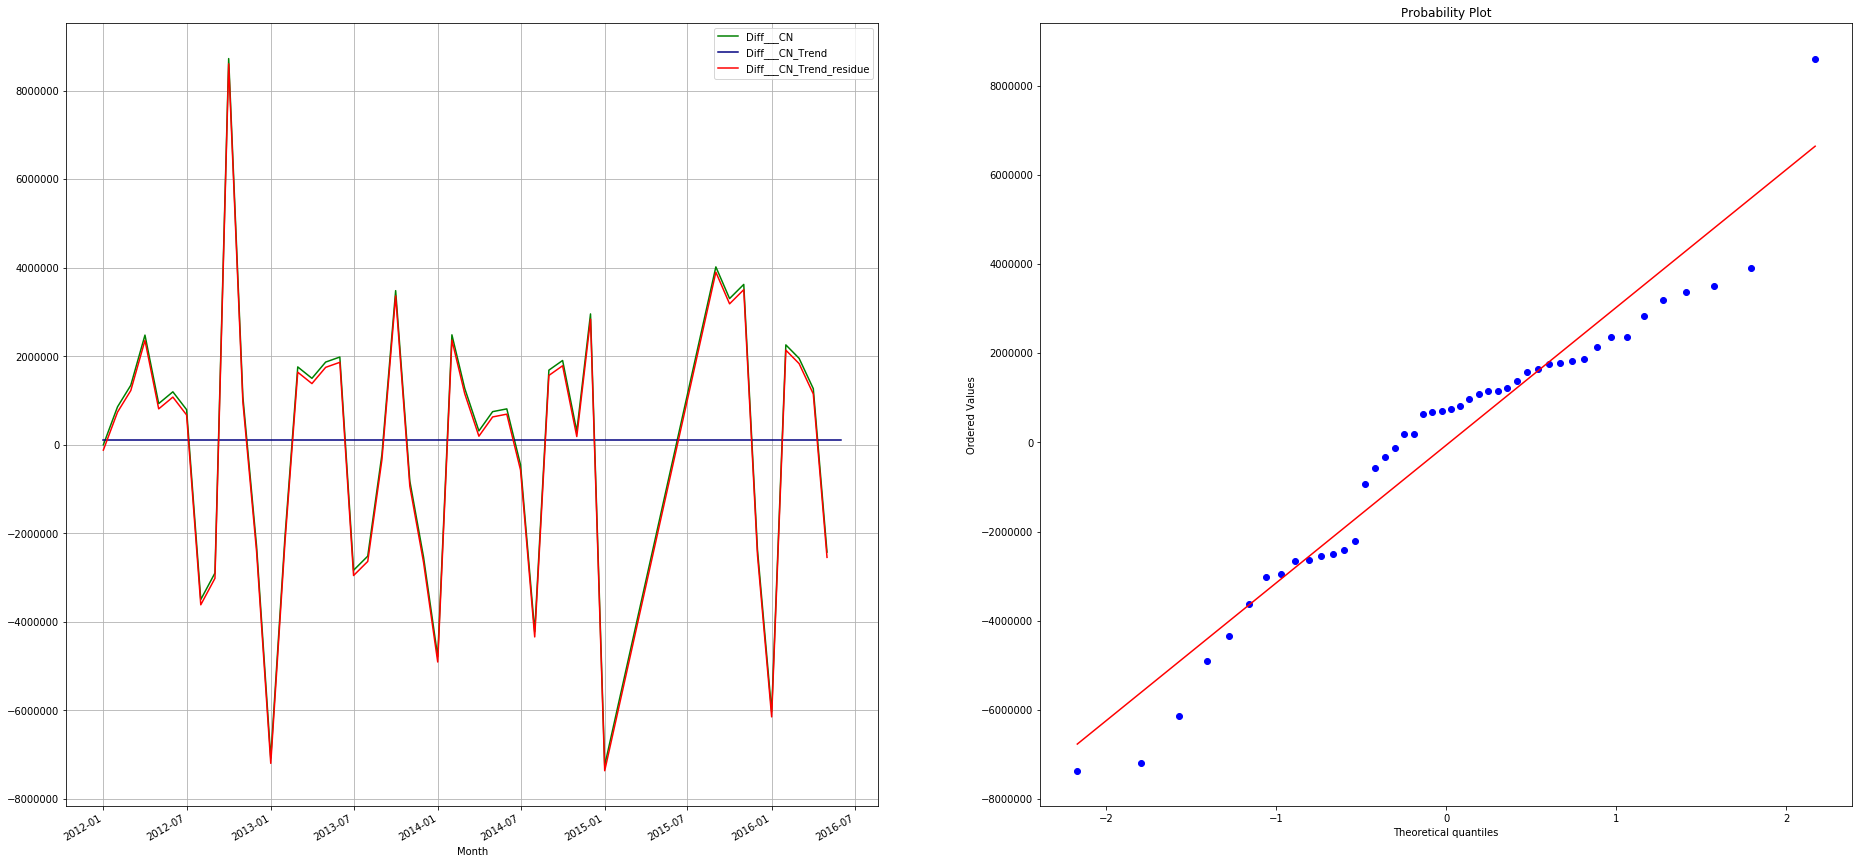

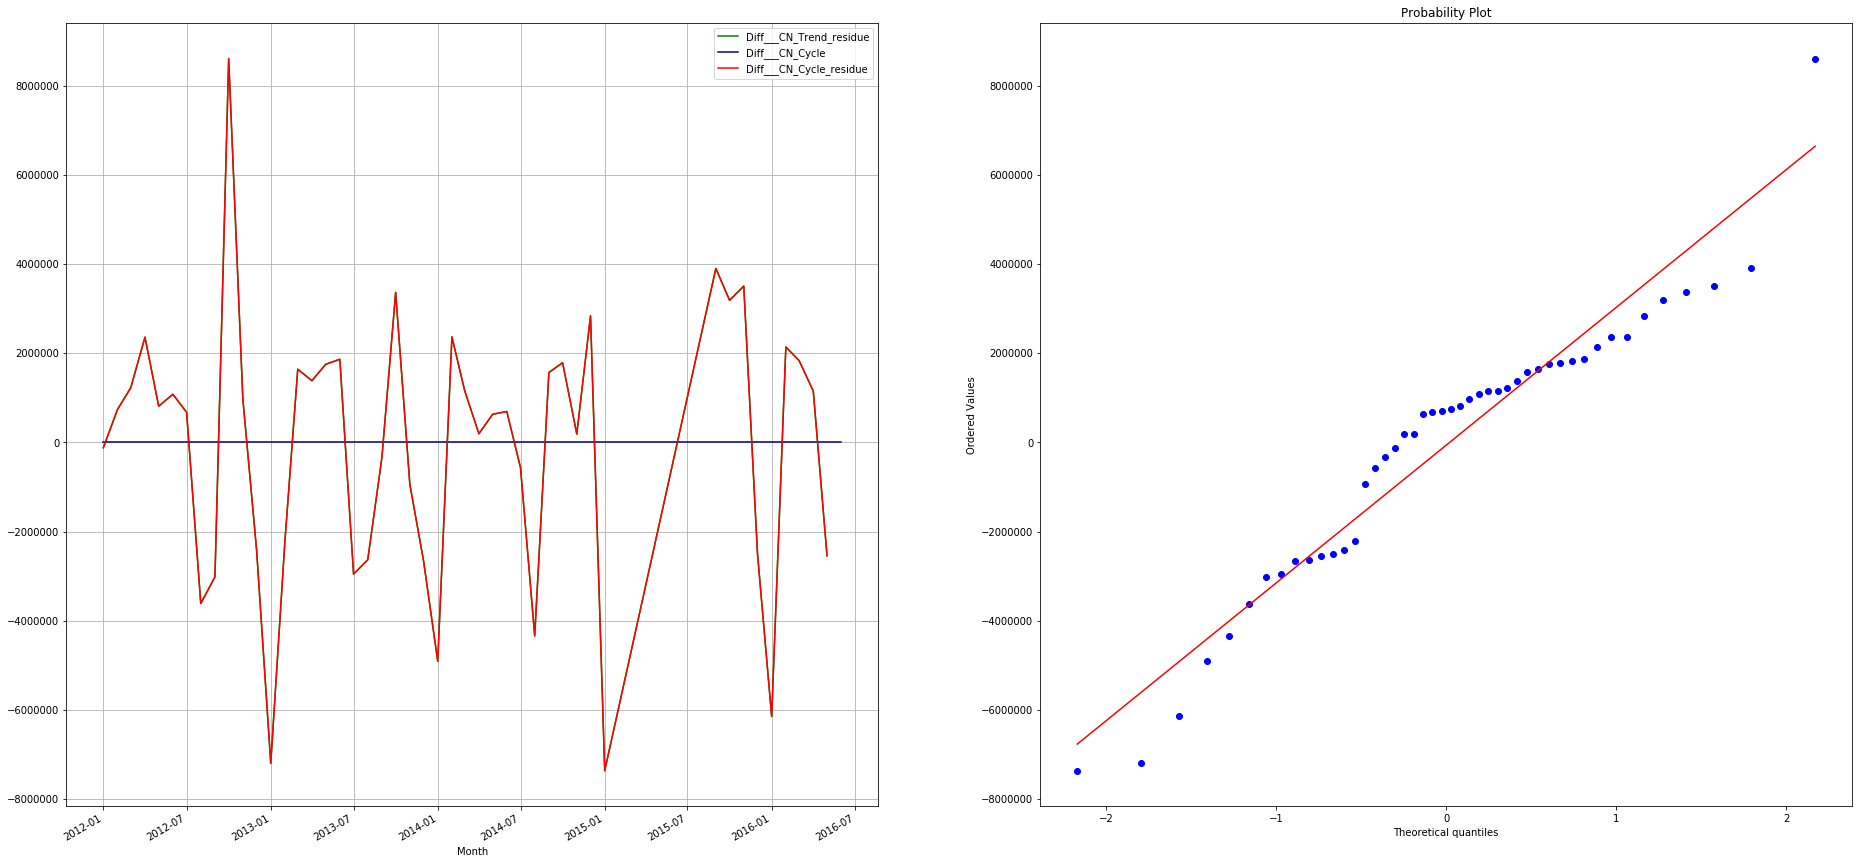

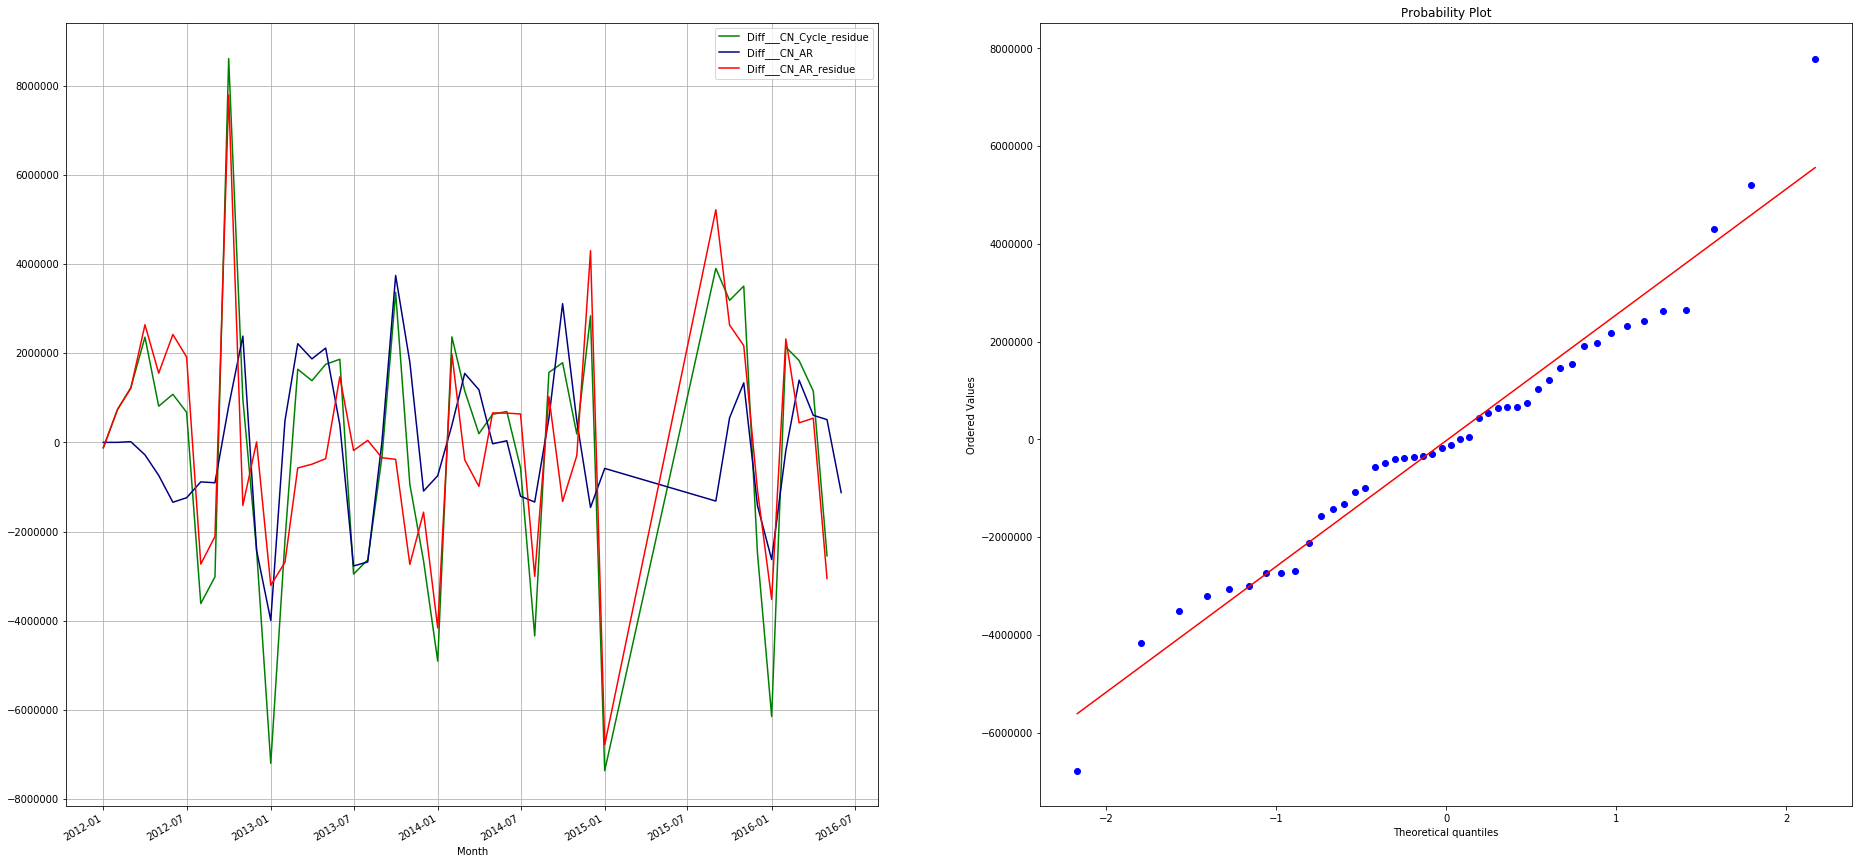

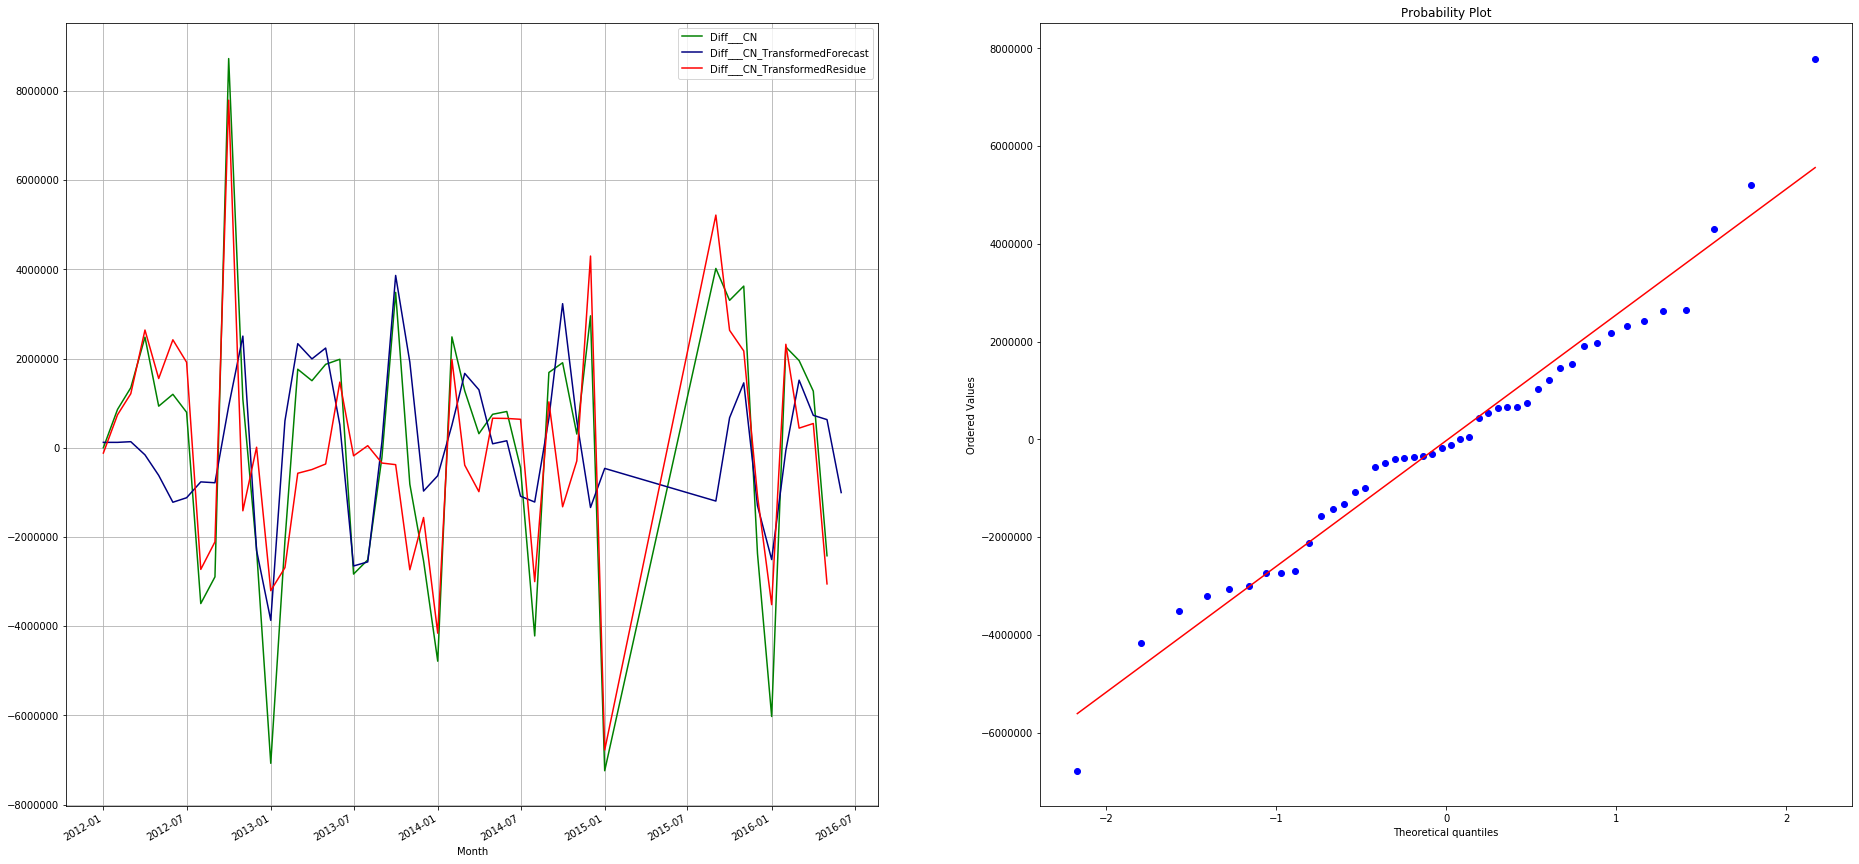

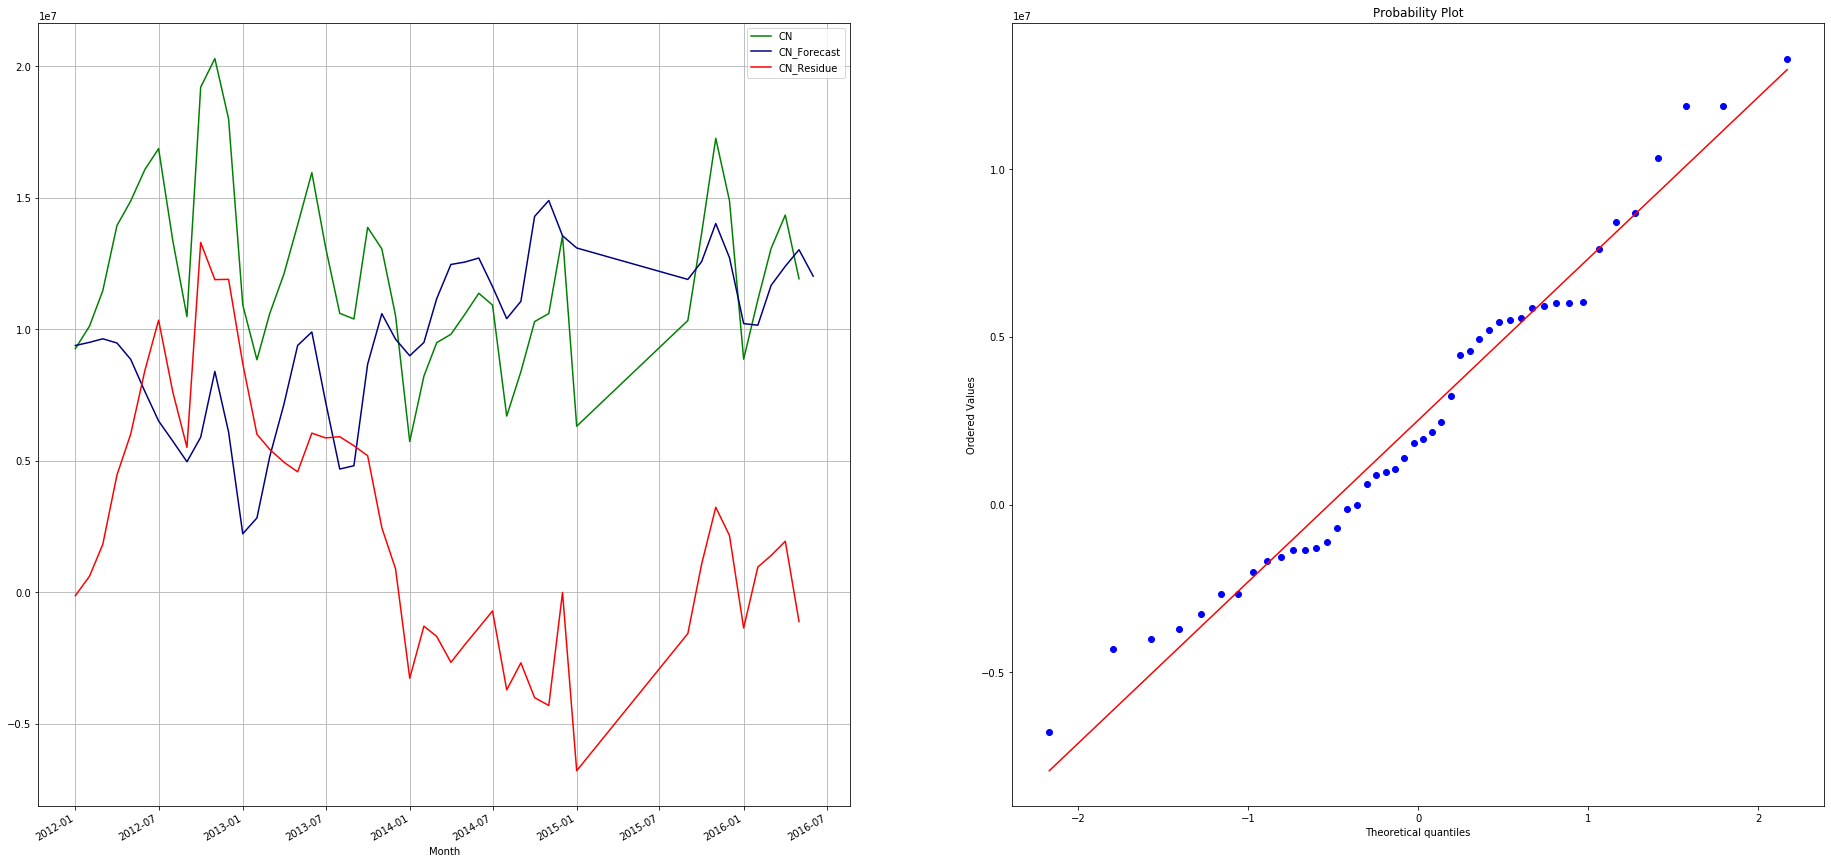

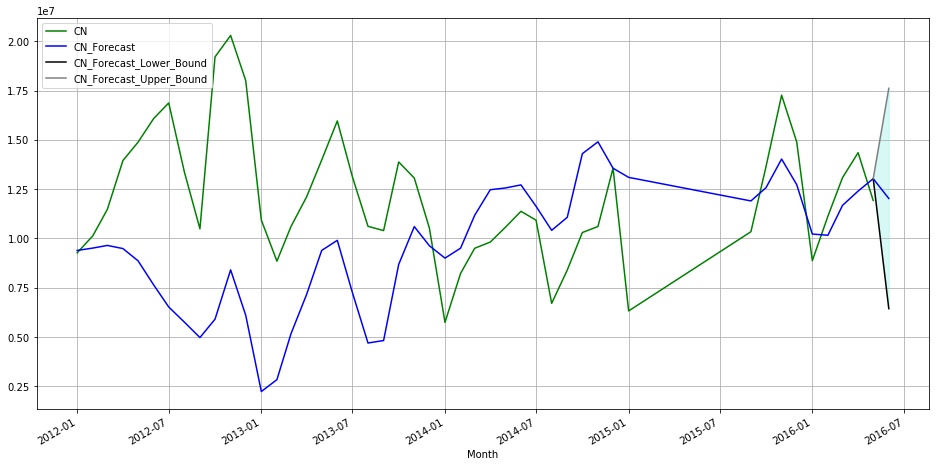

In [29]:
CN_Engine.standardPlots()

## Hierarchical Forecast Combinations


### Bottom-Up / Top-Down and Middle-Out Forecasts

In [30]:
lEngine.mOptions.mHierarchicalCombinationMethod = ["BU" , 'TD' , 'MO' , 'OC'];
dfapp_out = lEngine.forecast(train_df, H);


INFO:pyaf.std:START_HIERARCHICAL_FORECASTING
INFO:pyaf.hierarchical:FORECASTING_HIERARCHICAL_MODELS_LEVEL_SIGNAL [(0, 'ALSACE_BLANC_BE'), (0, 'ALSACE_BLANC_CN'), (0, 'ALSACE_BLANC_DE'), (0, 'ALSACE_BLANC_GB'), (0, 'ALSACE_BLANC_US'), (0, 'BEAUJOLAIS_ROUGE_BE'), (0, 'BEAUJOLAIS_ROUGE_CN'), (0, 'BEAUJOLAIS_ROUGE_DE'), (0, 'BEAUJOLAIS_ROUGE_GB'), (0, 'BEAUJOLAIS_ROUGE_US'), (0, 'BORDEAUX_BLANC_BE'), (0, 'BORDEAUX_BLANC_CN'), (0, 'BORDEAUX_BLANC_DE'), (0, 'BORDEAUX_BLANC_GB'), (0, 'BORDEAUX_BLANC_US'), (0, 'BORDEAUX_ROUGE_BE'), (0, 'BORDEAUX_ROUGE_CN'), (0, 'BORDEAUX_ROUGE_DE'), (0, 'BORDEAUX_ROUGE_GB'), (0, 'BORDEAUX_ROUGE_US'), (1, '_BLANC_BE'), (1, '_BLANC_CN'), (1, '_BLANC_DE'), (1, '_BLANC_GB'), (1, '_BLANC_US'), (1, '_ROUGE_BE'), (1, '_ROUGE_CN'), (1, '_ROUGE_DE'), (1, '_ROUGE_GB'), (1, '_ROUGE_US'), (2, '__BE'), (2, '__CN'), (2, '__DE'), (2, '__GB'), (2, '__US'), (3, '__')]
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.09225106239318848
INFO:pyaf.std:S

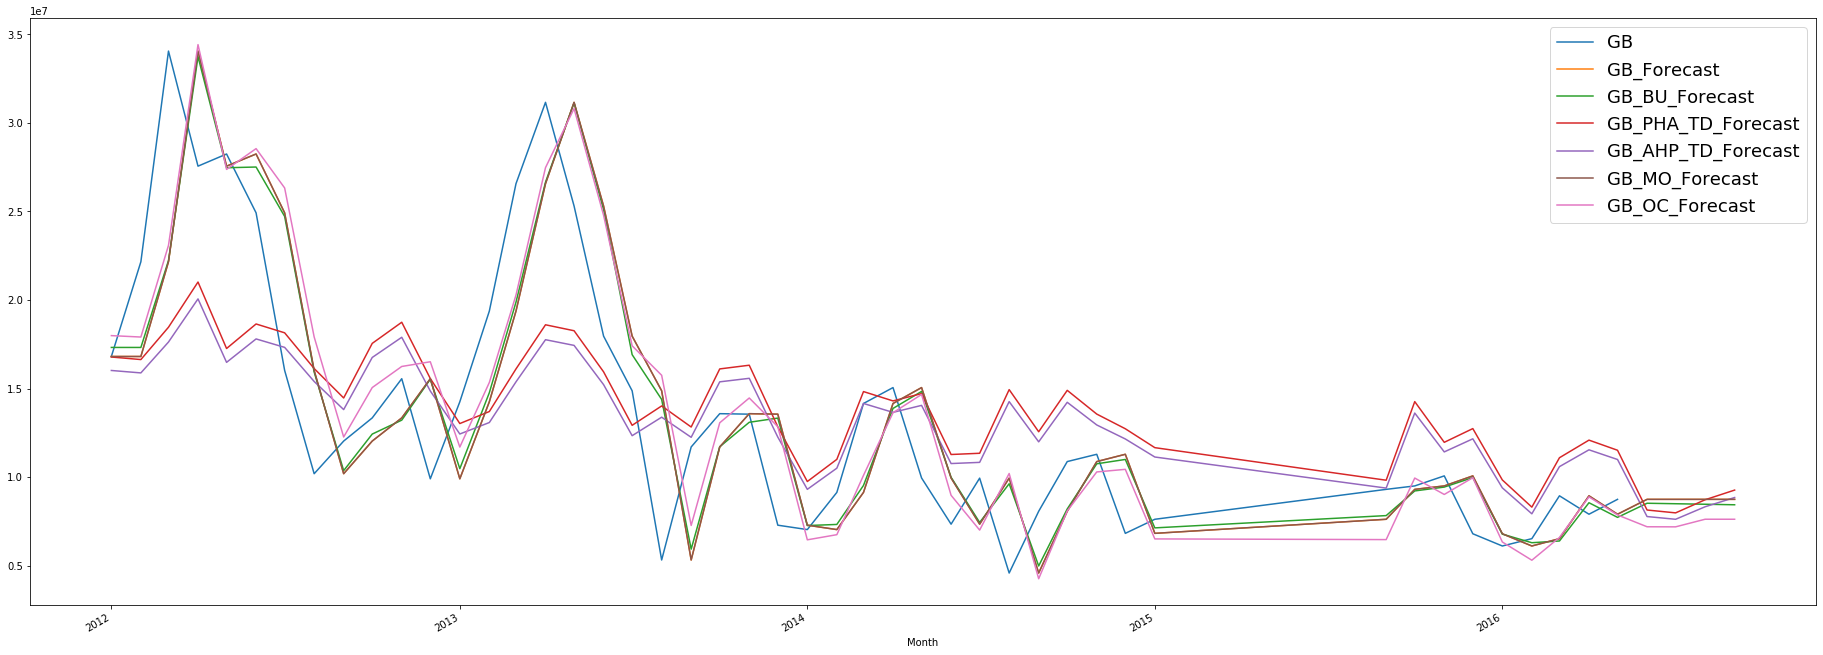

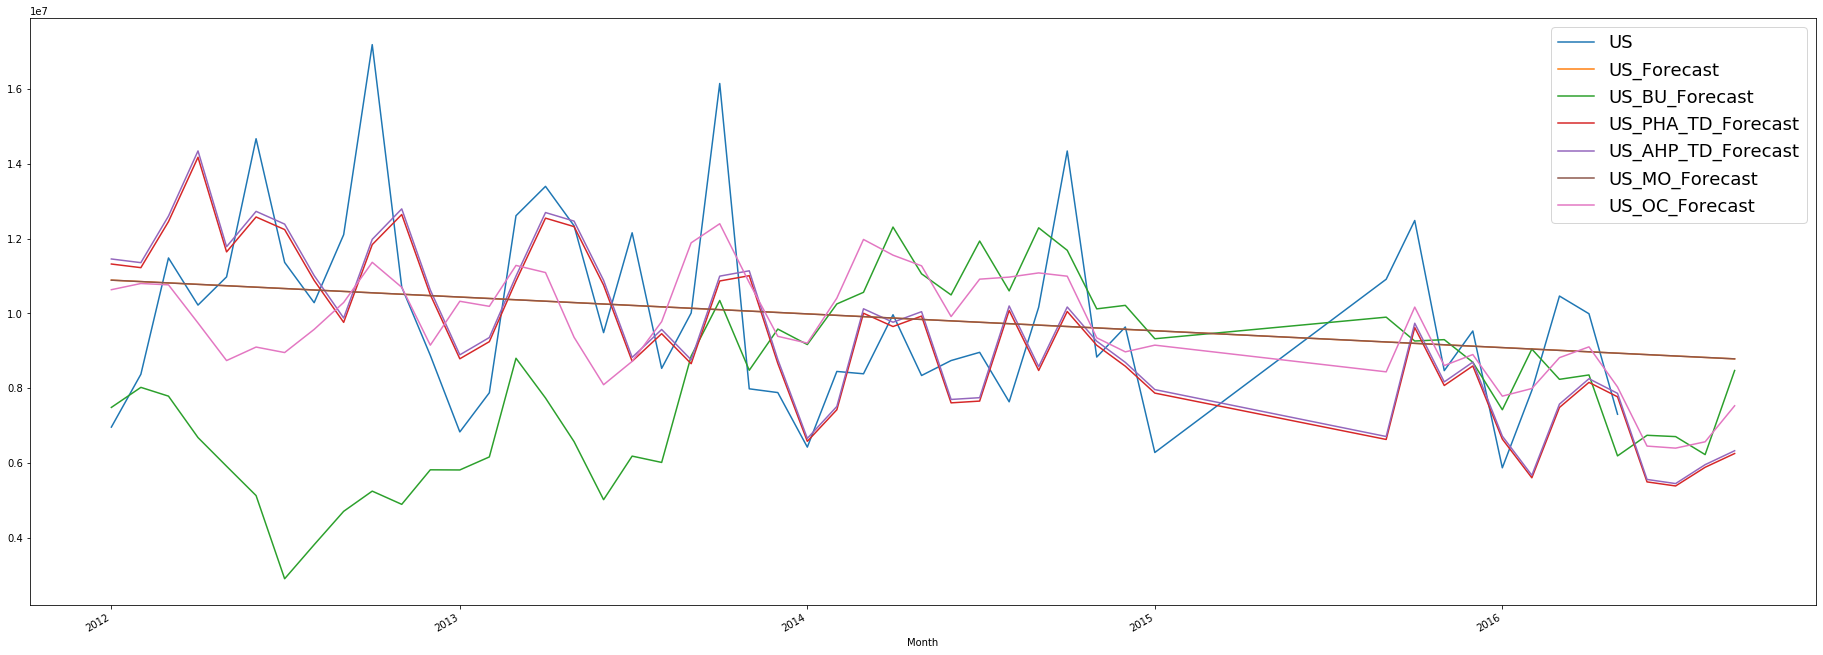

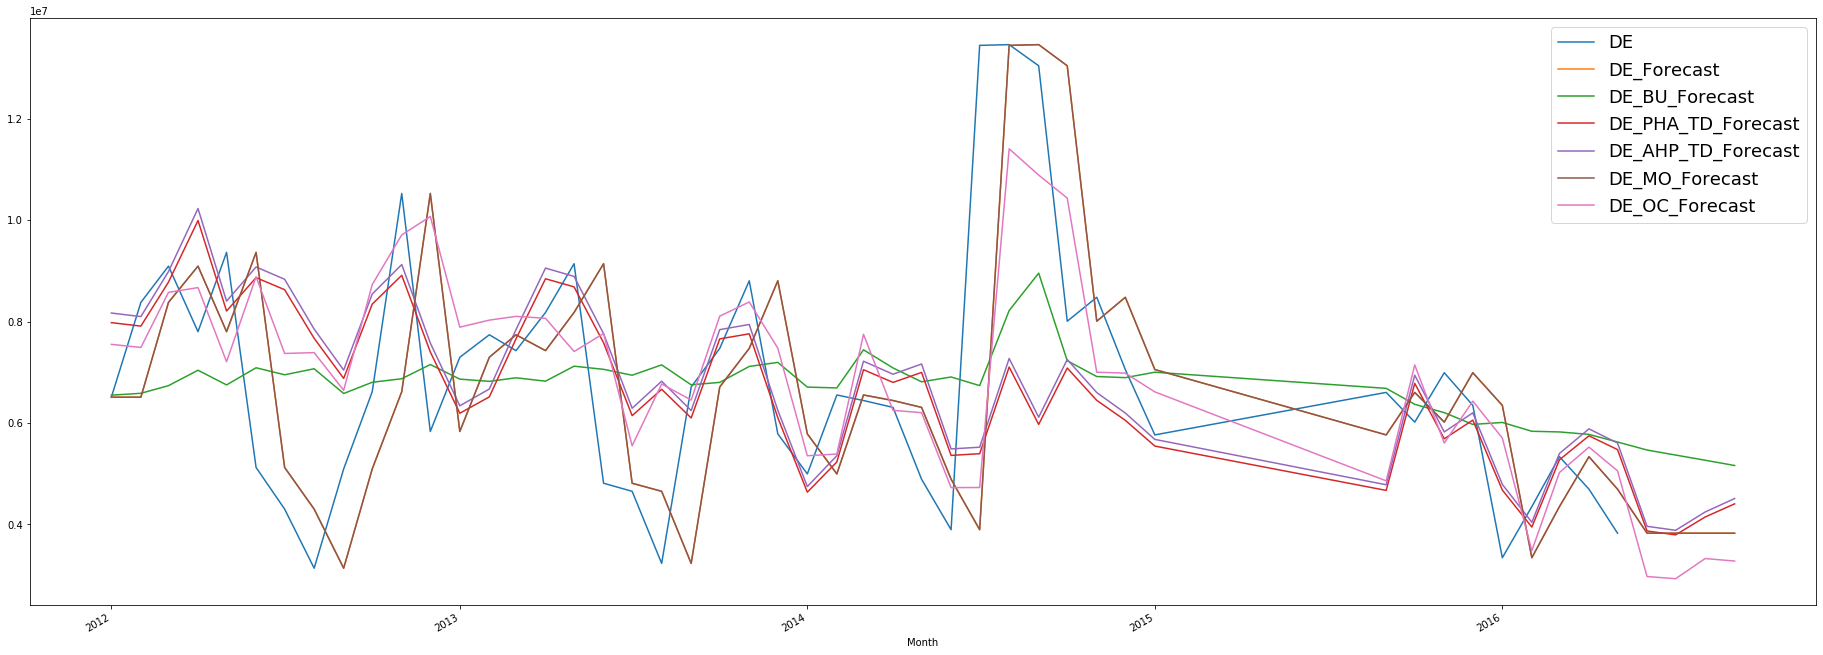

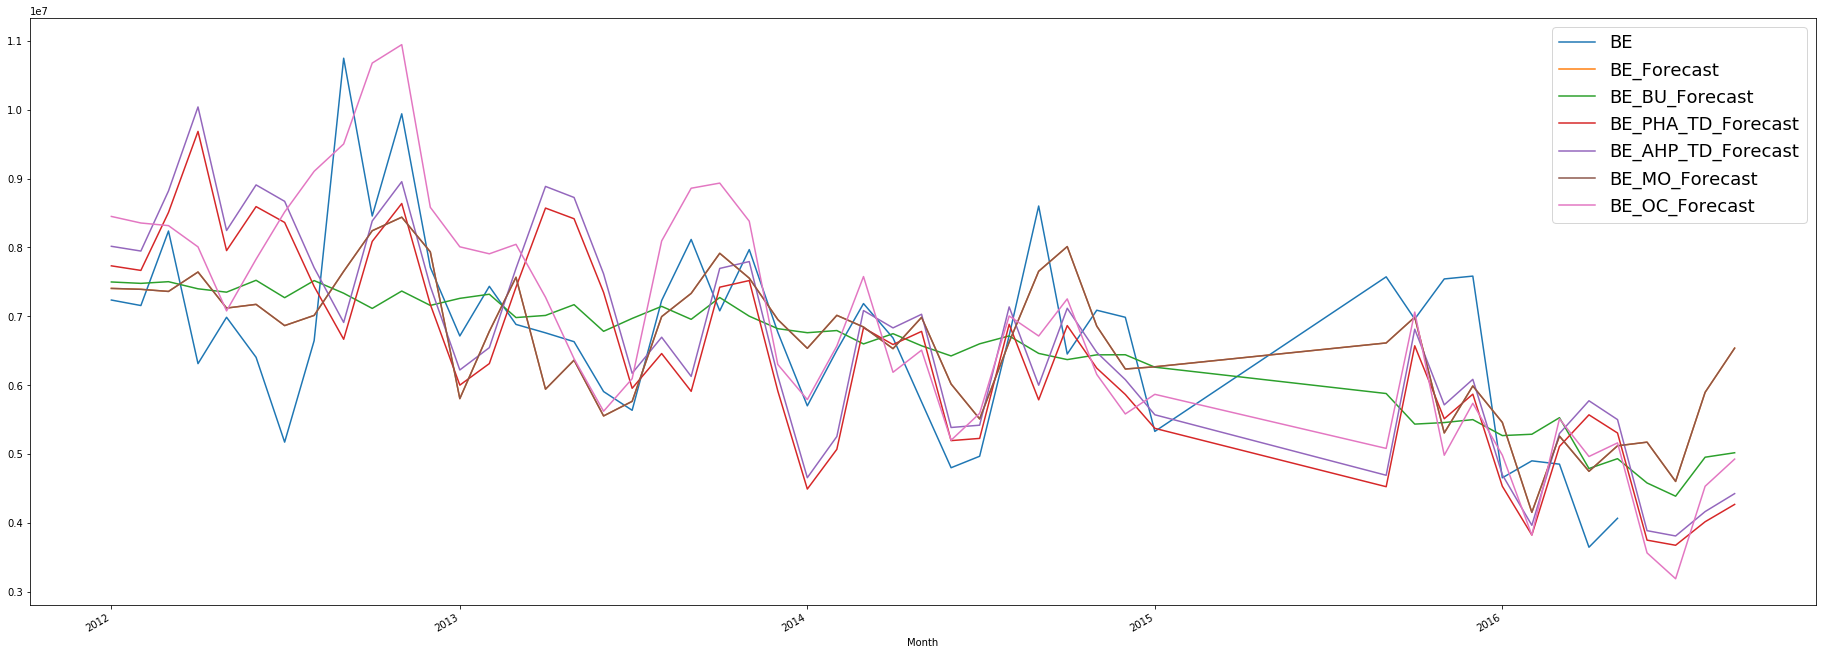

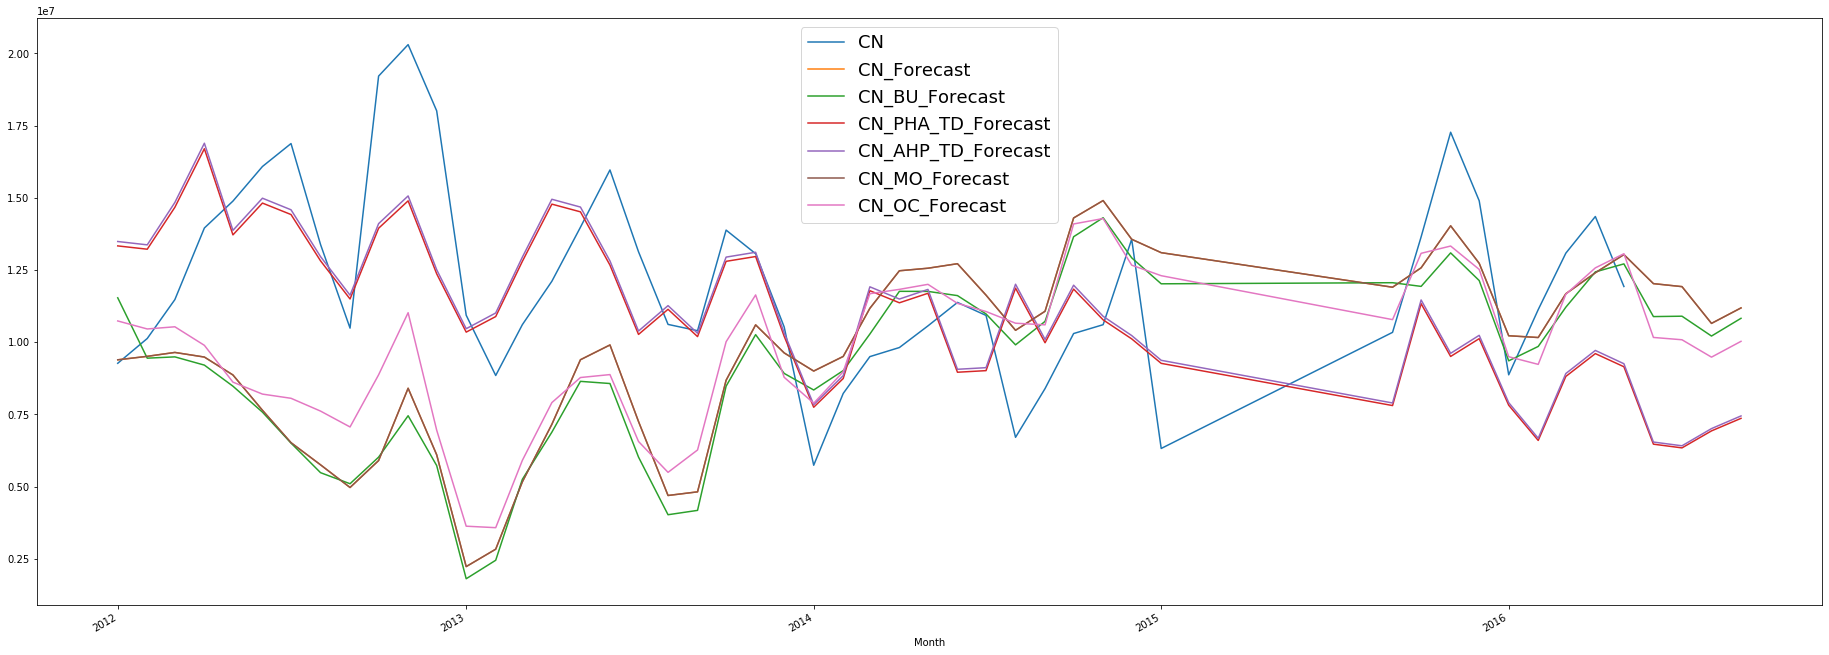

In [31]:
def strip_leading_underscores_if_needed(col_name):
    # this is a workaround for some matplotlib bugs. legend cannot contain names starting with '_'
    patched_name = col_name[2:] if(col_name.startswith('__')) else col_name
    patched_name = patched_name[1:] if(patched_name.startswith('_')) else patched_name
    return patched_name
    

dfapp_out.columns = [strip_leading_underscores_if_needed(col) for col in dfapp_out.columns]
for c in Countries:
    country = c
    dfapp_out.plot('Month' , 
                    [country , country + '_Forecast' , 
                     country + '_BU_Forecast',  
                     country + '_PHA_TD_Forecast',  
                     country + '_AHP_TD_Forecast'  ,  
                     country + '_MO_Forecast' ,
                     country + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

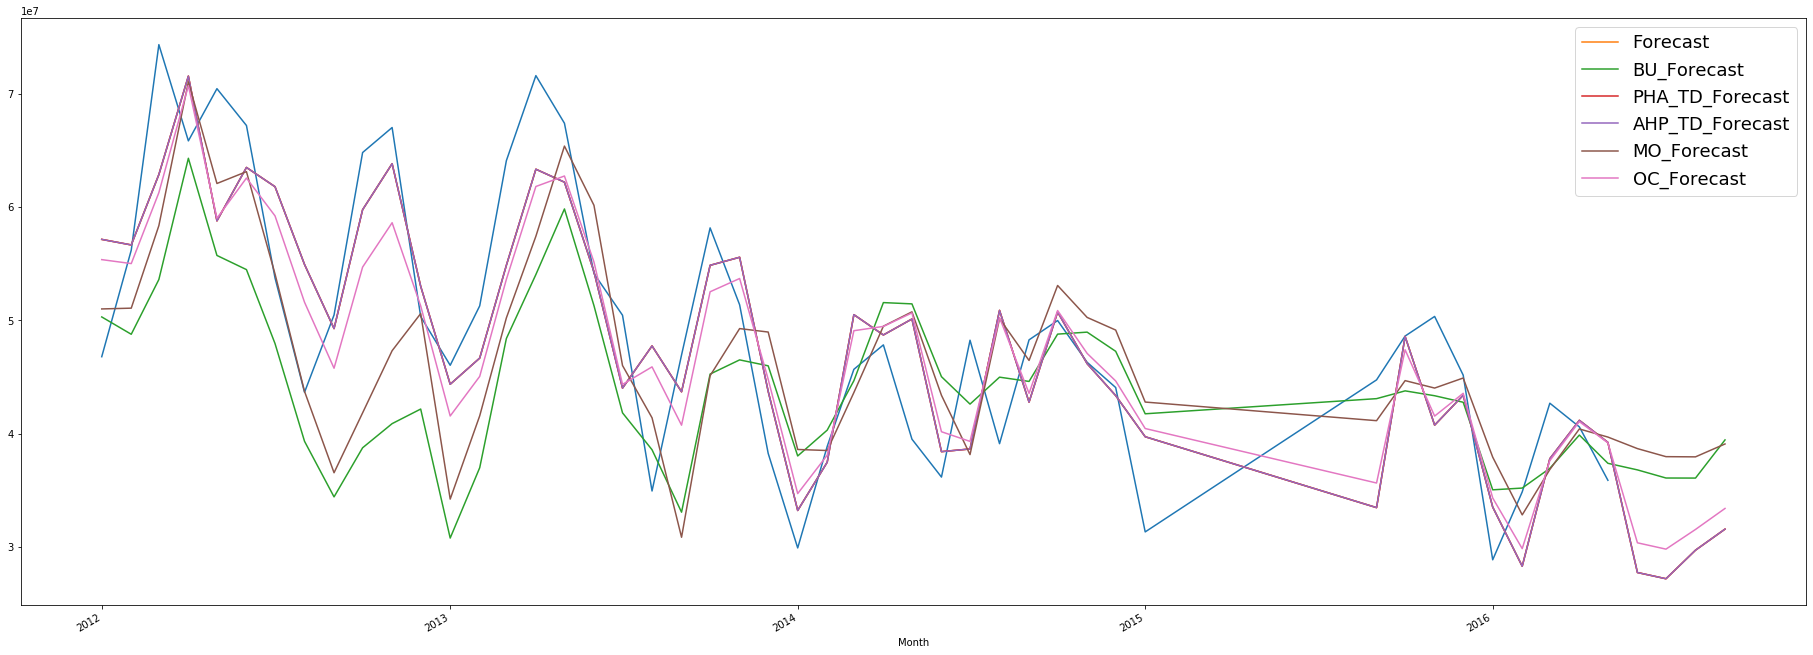

In [32]:
world = ''
dfapp_out.plot('Month' , 
                [world , world + 'Forecast' , 
                 world + 'BU_Forecast',  
                 world + 'PHA_TD_Forecast',  
                 world + 'AHP_TD_Forecast'  ,  
                 world + 'MO_Forecast' ,
                 world + 'OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

In [33]:
dfapp_out.columns

Index(['Month', 'ALSACE_BLANC_BE', 'ALSACE_BLANC_BE_Forecast',
       'ALSACE_BLANC_CN', 'ALSACE_BLANC_CN_Forecast', 'ALSACE_BLANC_DE',
       'ALSACE_BLANC_DE_Forecast', 'ALSACE_BLANC_GB',
       'ALSACE_BLANC_GB_Forecast', 'ALSACE_BLANC_US',
       ...
       'ROUGE_CN_OC_Forecast', 'ROUGE_DE_OC_Forecast', 'ROUGE_GB_OC_Forecast',
       'ROUGE_US_OC_Forecast', 'BE_OC_Forecast', 'CN_OC_Forecast',
       'DE_OC_Forecast', 'GB_OC_Forecast', 'US_OC_Forecast', 'OC_Forecast'],
      dtype='object', length=253)